In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

from midvoxio.voxio import vox_to_arr

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [10]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (1e-3,1e-3,1e-3),
            matrix_dims = (400,300,200),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=5.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=30, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=10, scale=0.0001, label=3)

pos = 0.7

# test_phantom.add_tissue_sphere((pos,-pos,0), 8, blood)
# test_phantom.add_tissue_sphere((pos,0,0), 16, blood)
# test_phantom.add_tissue_sphere((pos,pos,0), 32, blood)

# test_phantom.add_tissue_sphere((-pos,-pos,0), 16, fat)
# test_phantom.add_tissue_sphere((-pos,0,0), 32, fat)
# test_phantom.add_tissue_sphere((-pos,pos,0), 8, fat)

# test_phantom.add_tissue_sphere((0,0,0), 24, myocardium)
# test_phantom.add_tissue_sphere((0.2,0,0), 8, fat)
# test_phantom.add_tissue_sphere((0.3,0,0), 4, blood)
# test_phantom.add_tissue_sphere((0,0.3,0), 4, blood)
# scalar = 5
# test_phantom.add_tissue_sphere(scalar * np.array((-0.1,0,0)), 8, fat)
# test_phantom.add_tissue_sphere(scalar * np.array((-0.065,0,0)), 4, fat)
mask = np.zeros(test_phantom.matrix_dims)
mask[60:340,60:340,60:340] = 1
# mask[:,:,::2] = 2
mask[95:205,95:205,95:205] = 3

test_phantom.add_tissue(blood, mask == 1)
# test_phantom.add_tissue(fat, mask == 2)
test_phantom.add_tissue(myocardium, mask == 3)

test_phantom.mask = mask
test_phantom.from_mask = True
test_phantom.complete = None

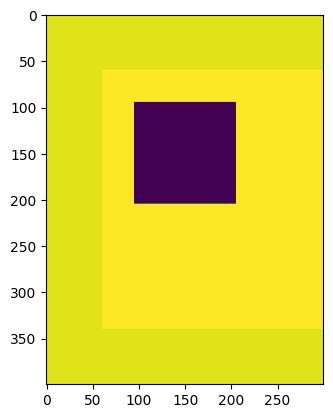

In [11]:
plt.imshow(test_phantom.get_complete()[0,:,:,test_phantom.matrix_dims[2]//2])

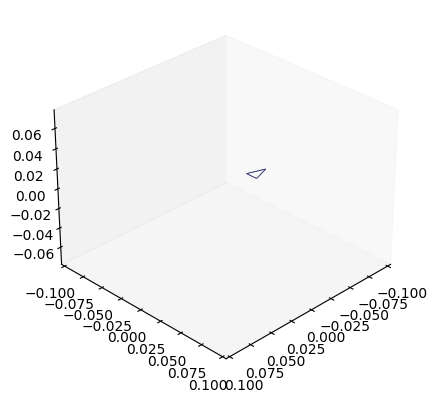

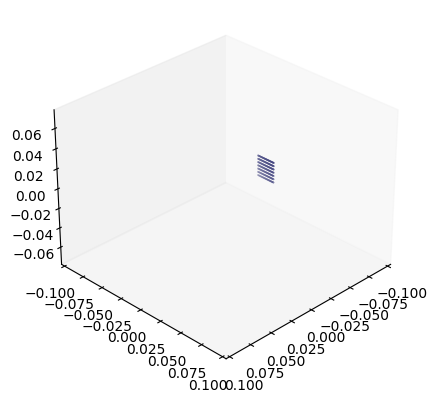

In [18]:
num_transducers = 1

transducers = [transducer.Focused(max_frequency = 0.3e6,
                                  elements = 32, 
                                  width = 20e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/5,
                                  ray_num = 3,
                                  imaging_ndims = 2,
                                  focus_azimuth = 100e-3,
                                  focus_elevation = 100e-3)]

for t in transducers:
    t.make_sensor_coords(1540)

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

test_transducer_set.assign_pose(0, geometry.Transform(translation=(-0.05,0,0), rot_vec =(0,0,0)))

test_transducer_set.plot_transducer_fovs(scale=0.1, view=(30,45))
test_transducer_set.plot_transducer_coords(scale=0.1, view=(30,45))


In [19]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [20]:
simprops = simulation.SimProperties(
                grid_size   = (150e-3,80e-3,80e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [21]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/kidney_experiment_01',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )


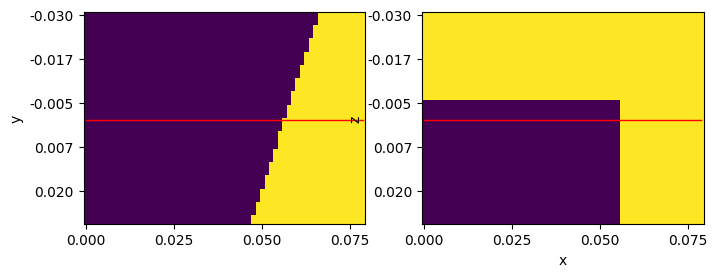

In [22]:
test_experiment.plot_ray_path(0)

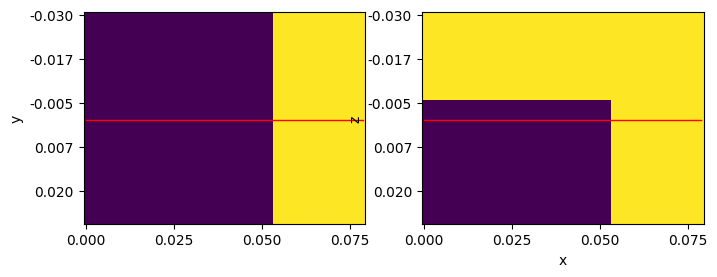

In [23]:
test_experiment.plot_ray_path(1)